In [ ]:
#!pip install timm -q
#!pip install albumentations -q

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timm import create_model, list_models
from types import SimpleNamespace
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from tqdm.auto import tqdm
import gc
import json

In [2]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


In [3]:
sample_tfms = [
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.ColorJitter(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3),
]
train_tfms = A.Compose([
    *sample_tfms,
    A.Resize(224,224),
    A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
    ToTensorV2()
])
valid_tfms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
    ToTensorV2()
])

In [4]:
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token

'<|endoftext|>'

In [5]:
tokenizer.encode_plus('hello! this is a caption')

{'input_ids': [31373, 0, 428, 318, 257, 8305], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [6]:
class Dataset:
    def __init__(self, df, tfms):
        self.df = df
        self.tfms = tfms
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        sample = self.df.iloc[idx,:]
        image = sample['image']
        caption = sample['caption']
        image = Image.open(image).convert('RGB')
        image = np.array(image)
        augs = self.tfms(image=image)
        image = augs['image']
        caption = f"{caption}<|endoftext|>"
        input_ids = tokenizer(
            caption,
            truncation=True)['input_ids']
        labels = input_ids.copy()
        labels[:-1] = input_ids[1:]
        return image,input_ids,labels

In [7]:
#ls ../Valid/

In [10]:
train_path = "../Training/"

train_df=  pd.read_csv("train_captions.csv")
train_df.rename(columns={'ID':'image'}, inplace=True)
train_df.rename(columns={'Caption':'caption'}, inplace=True)


for i in range (len(train_df)):
    train_df.at[i, 'image'] = train_path+train_df.at[i, 'image']+'.jpg'
    
print (train_df.head())
print ("# of Training Images: ",len(train_df))

                                               image  \
0  ../Training/ImageCLEFmedical_Caption_2024_trai...   
1  ../Training/ImageCLEFmedical_Caption_2024_trai...   
2  ../Training/ImageCLEFmedical_Caption_2024_trai...   
3  ../Training/ImageCLEFmedical_Caption_2024_trai...   
4  ../Training/ImageCLEFmedical_Caption_2024_trai...   

                                             caption  
0            Head CT demonstrating left parotiditis.  
1  Acquired renal cysts in end-stage renal failur...  
2  Computed tomography of the chest showing the r...  
3  Lateral view of the sacrum showing the low con...  
4  Thoracic CT scan showing perihilar pulmonary l...  
# of Training Images:  70108


Sample Training Images


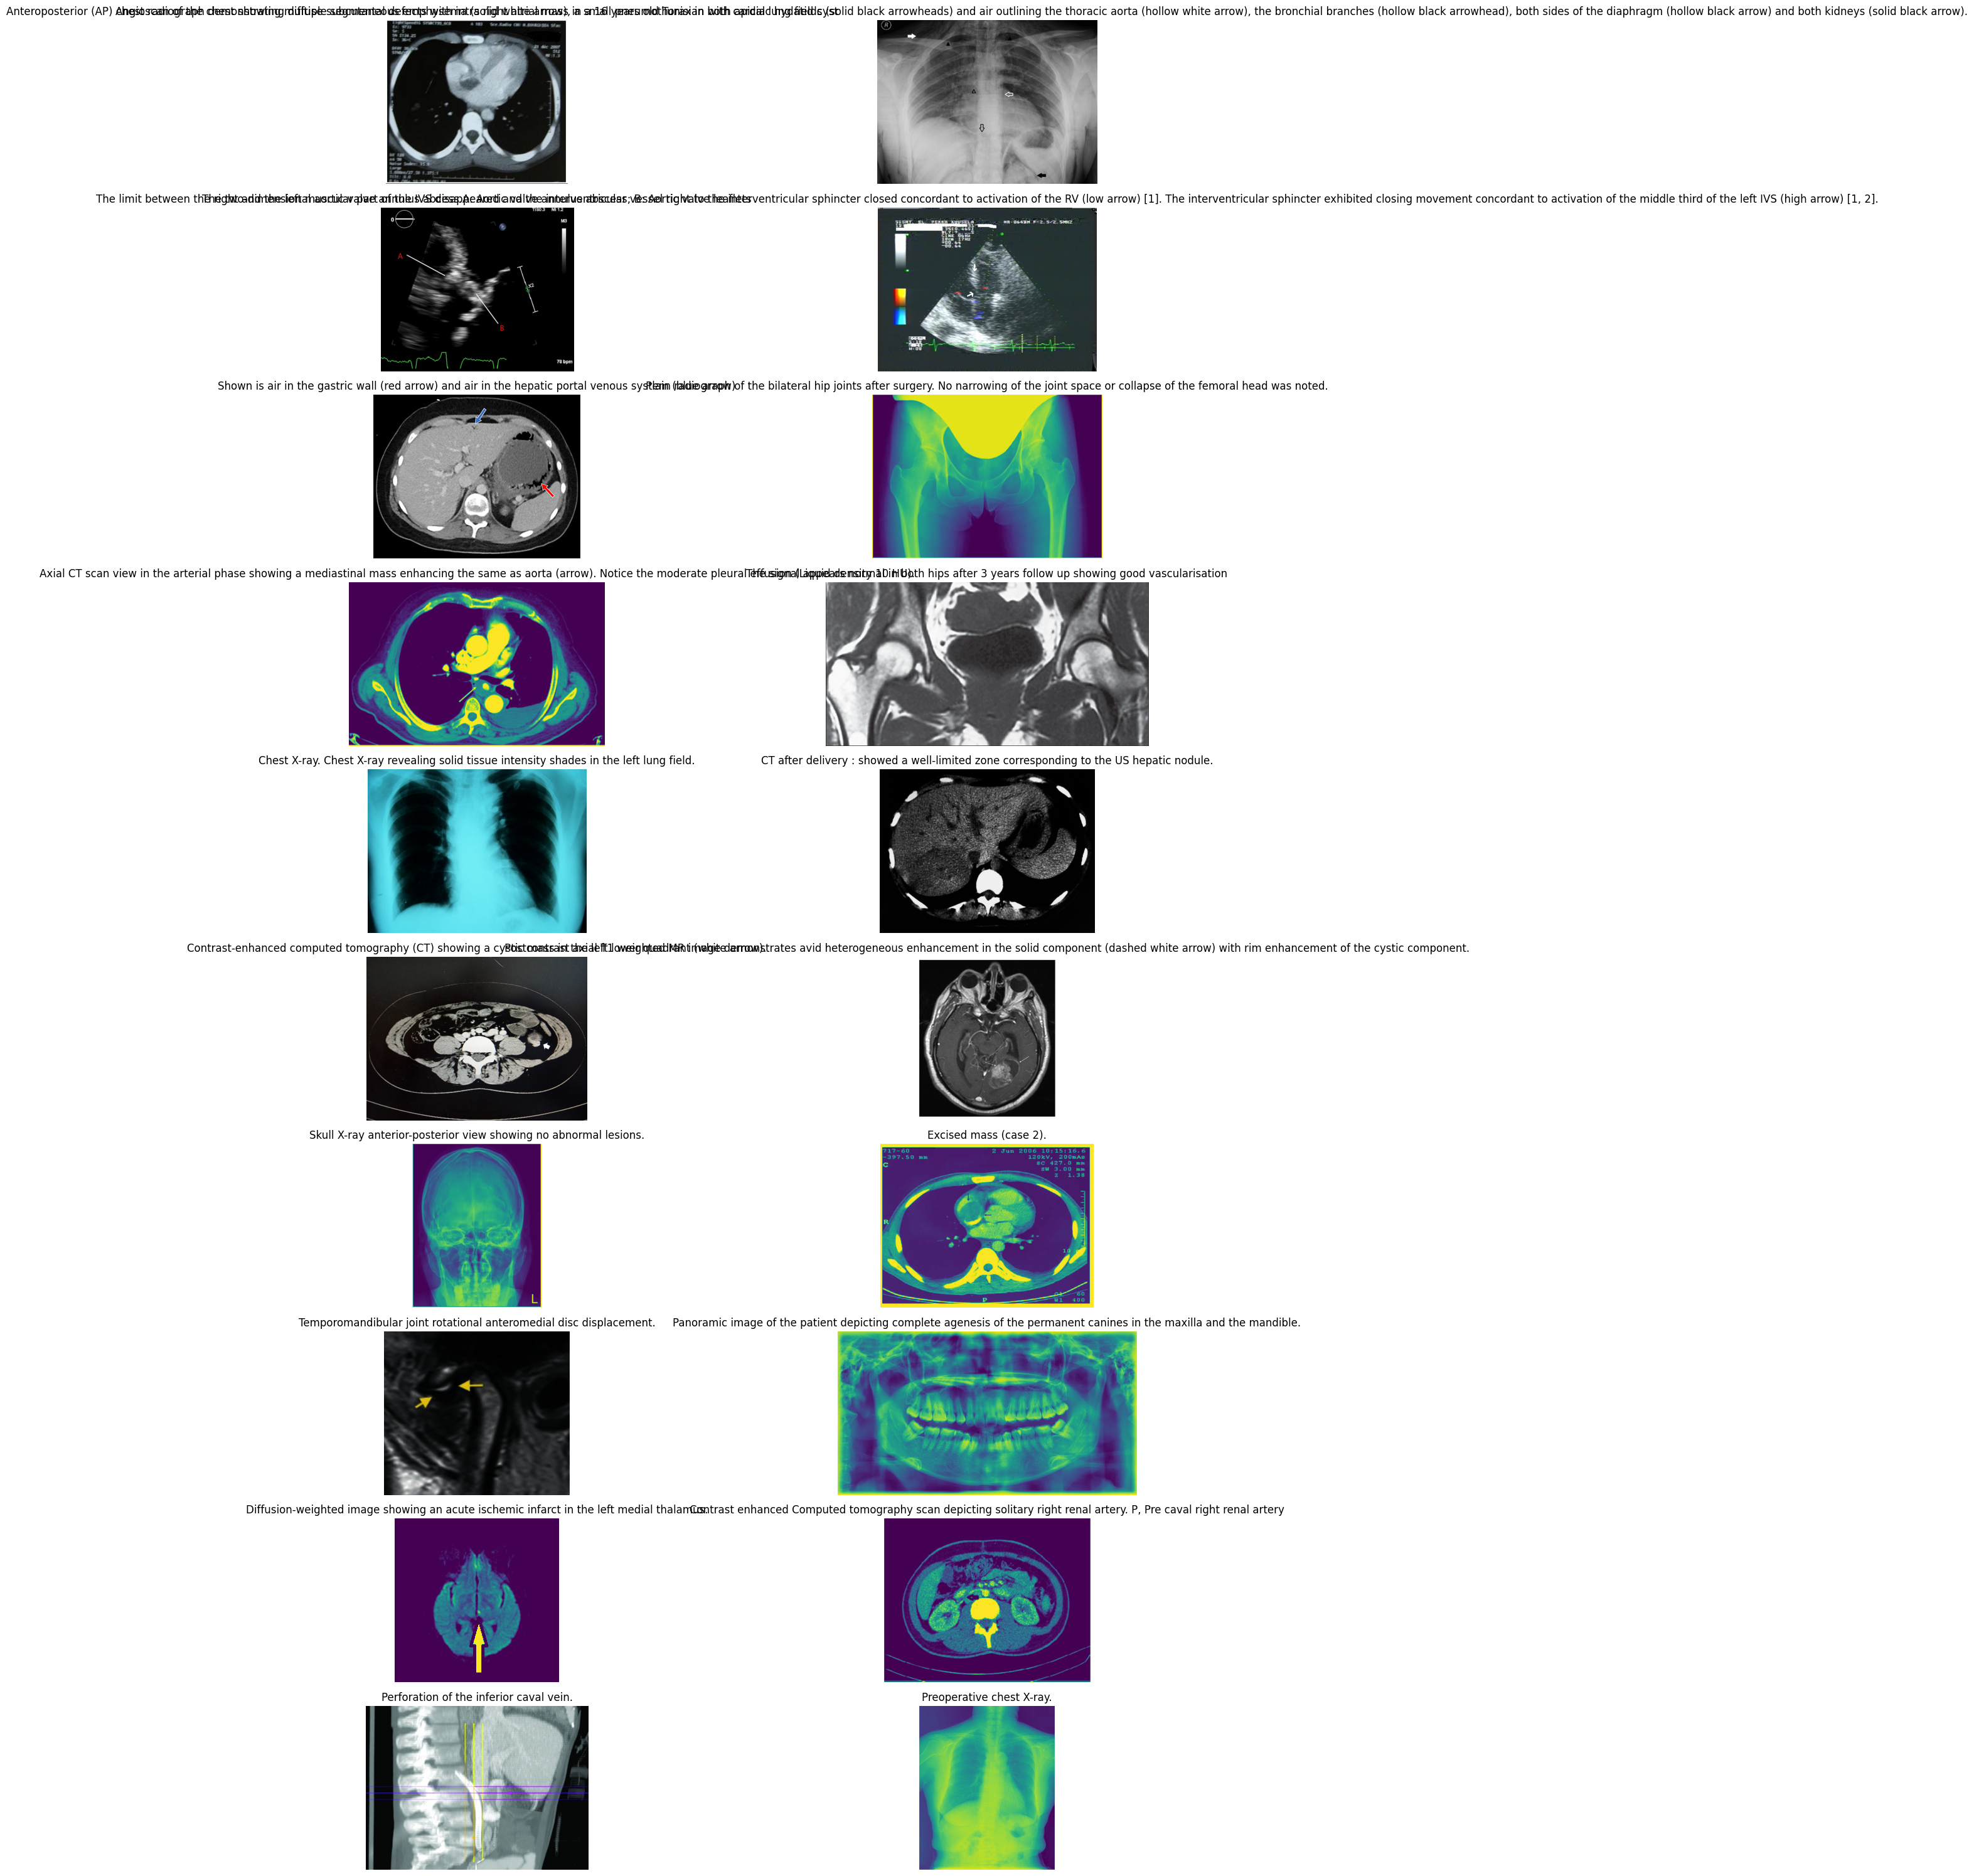

In [11]:
print ("Sample Training Images")

sampled_df = train_df.sample(n=20)
fig, axs = plt.subplots(10, 2, figsize=(20, 30))

for i, row in enumerate(sampled_df.iterrows()):
    ax = axs[i // 2, i % 2]
    image_path = row[1]['image']
    caption = row[1]['caption']
    image = Image.open(image_path)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(caption)

plt.tight_layout()
plt.show()

In [9]:
valid_path = "../Valid/"

val_df=  pd.read_csv("valid_captions.csv")
val_df.rename(columns={'ID':'image'}, inplace=True)
val_df.rename(columns={'Caption':'caption'}, inplace=True)


for i in range (len(val_df)):
    val_df.at[i, 'image'] = valid_path+val_df.at[i, 'image']+'.jpg'

print (val_df.head())
print ("# of Training Images: ",len(val_df))

                                               image  \
0  ../Valid/ImageCLEFmedical_Caption_2024_valid_0...   
1  ../Valid/ImageCLEFmedical_Caption_2024_valid_0...   
2  ../Valid/ImageCLEFmedical_Caption_2024_valid_0...   
3  ../Valid/ImageCLEFmedical_Caption_2024_valid_0...   
4  ../Valid/ImageCLEFmedical_Caption_2024_valid_0...   

                                             caption  
0  CT chest axial view showing a huge ascending a...  
1  Computed tomography (CT) shows floating thromb...  
2  Digitally subtracted angiogram demonstrates ac...  
3  Digitally subtracted angiogram of the IMA demo...  
4               Angle measurement of a Type 1 canal.  
# of Training Images:  9972


Sample Validation Images


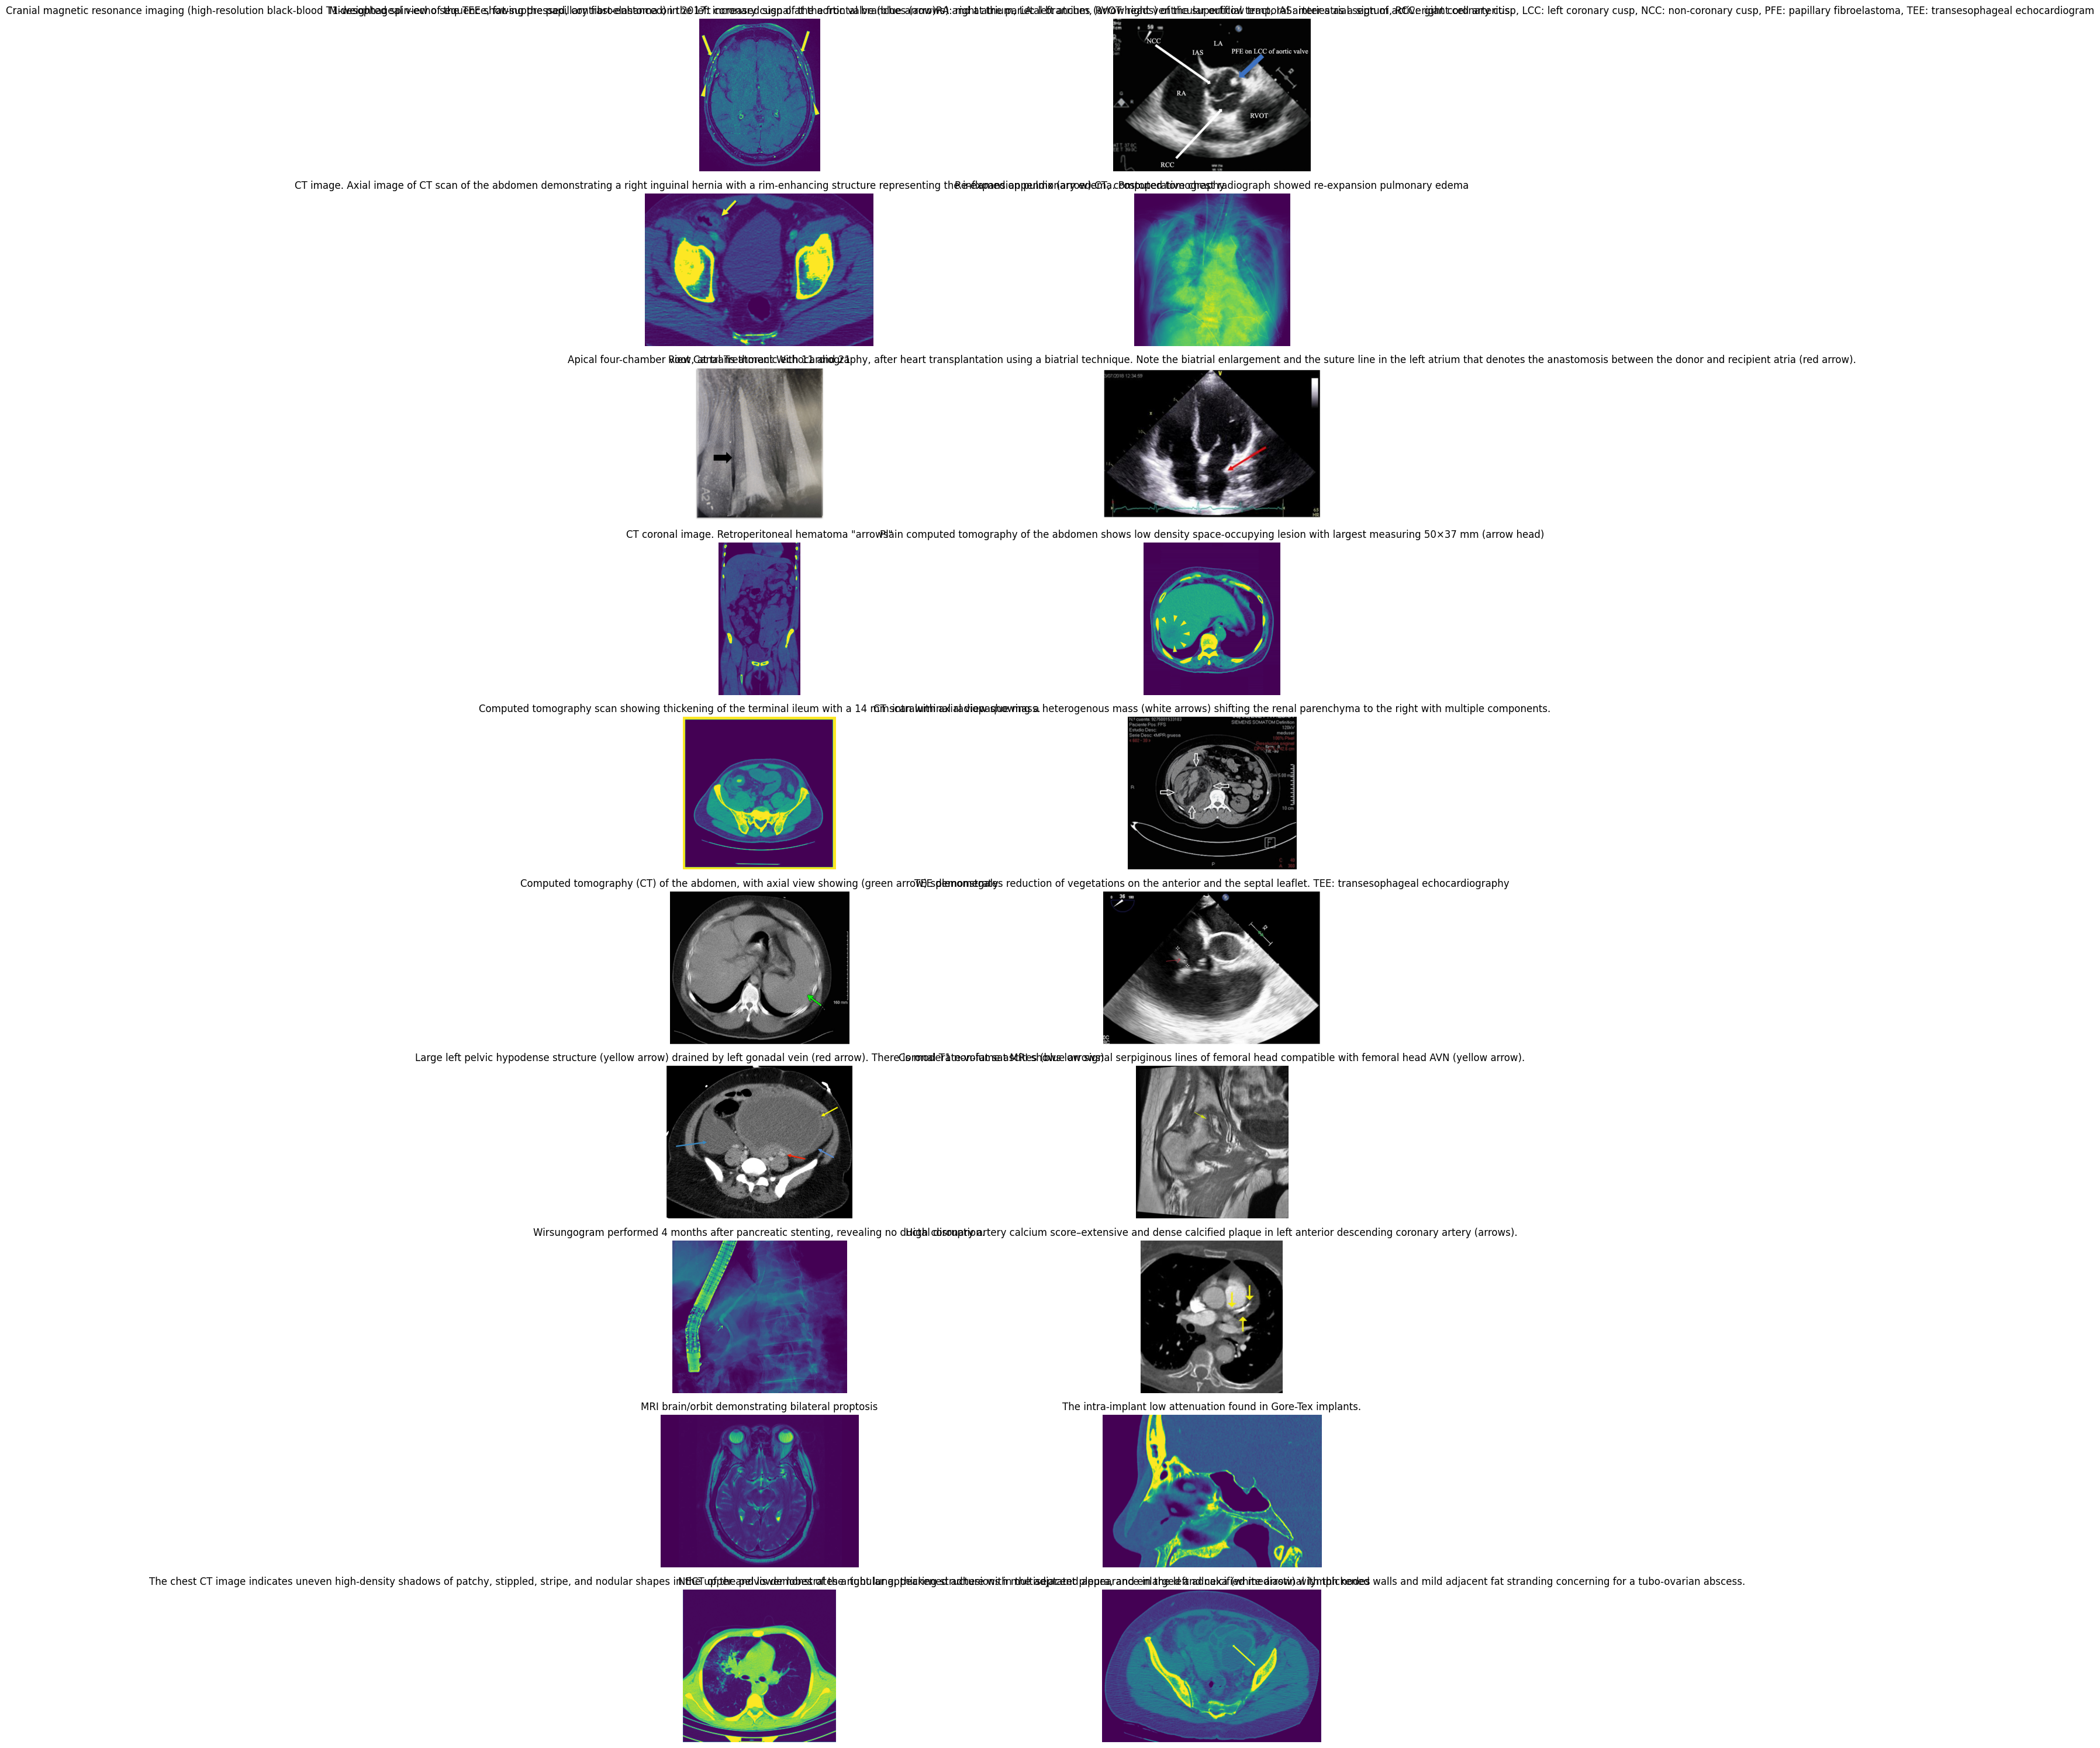

In [12]:
print ("Sample Validation Images")

sampled_df = val_df.sample(n=20)
fig, axs = plt.subplots(10, 2, figsize=(20, 30))

for i, row in enumerate(sampled_df.iterrows()):
    ax = axs[i // 2, i % 2]
    image_path = row[1]['image']
    caption = row[1]['caption']
    image = Image.open(image_path)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(caption)

plt.tight_layout()
plt.show()

In [13]:
train_df, val_df = train_test_split(val_df,test_size=0.1)
train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)
print(len(train_df),len(val_df))

8974 998


In [14]:
train_ds = Dataset(train_df,train_tfms)
val_ds = Dataset(val_df,valid_tfms)

In [15]:
def collate_fn(batch):
    image = [i[0] for i in batch]
    input_ids = [i[1] for i in batch]
    labels = [i[2] for i in batch]
    image = torch.stack(image,dim=0)
    input_ids = tokenizer.pad(
        {'input_ids':input_ids},
        padding='longest',
        return_attention_mask=False,
        return_tensors='pt'
    )['input_ids']
    labels = tokenizer.pad(
        {'input_ids':labels},
        padding='longest',
        return_attention_mask=False,
        return_tensors='pt'
    )['input_ids']
    mask = (input_ids!=tokenizer.pad_token_id).long()
    labels[mask==0]=-100
    return image, input_ids, labels

In [16]:
dl = torch.utils.data.DataLoader(train_ds,shuffle=True,batch_size=2,collate_fn=collate_fn)
_,c,l = next(iter(dl))
print(c[0])
print(l[0])

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([10606, 20996, 16356, 32956,  4478,  1402, 45426,   357, 36022, 15452,
            8, 20736,   319,   262,   826,  1735,   290,   262,  7633,   357,
        11186, 15452,     8, 20736,   319,   262,  1364,  1735, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256])
tensor([20996, 16356, 32956,  4478,  1402, 45426,   357, 36022, 15452,     8,
        20736,   319,   262,   826,  1735,   290,   262,  7633,   357, 11186,
        15452,     8, 20736,   319,   262,  1364,  1735, 50256,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100])


In [17]:
class GPT2Attention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        
        self.c_attn = nn.Linear(self.embed_dim, self.head_size * self.n_heads * 3,bias=True)
        self.scale = self.head_size ** -0.5
        
        self.register_buffer('mask',torch.tril(torch.ones(1,1,self.seq_len,self.seq_len)))
        
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        
        
    def forward(self, x):
        b,t,c = x.shape
        # q,k,v shape individually: batch_size x seq_len x embed_dim
        # we know that qk_t = q x k_t, where q=bxtxhead_dim, k_t=bxhead_timxt
        q,k,v = self.c_attn(x).chunk(3,dim=-1)
        q = q.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        
        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = qk_t.masked_fill(self.mask[:,:,:t,:t]==0,float('-inf'))
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)
        
        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim
        
        out = self.c_proj(attention)
        out = self.resid_dropout(out)
        
        return out

In [18]:
class GPT2CrossAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        
        self.q = nn.Linear(self.embed_dim,self.embed_dim)
        self.k = nn.Linear(self.embed_dim,self.embed_dim)
        self.v = nn.Linear(self.embed_dim,self.embed_dim)
        self.scale = self.head_size ** -0.5
        
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        
        
    def forward(self, q,k,v):
        b,t,c = q.shape
        
        q = self.q(q)
        k = self.k(k)
        v = self.v(v)
        
        q = q.view(b,q.size(1),self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,k.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,v.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        
        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)
        
        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim
        
        out = self.c_proj(attention)
        out = self.resid_dropout(out)
        
        return out

In [19]:
class GPT2MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.mlp_ratio = config.mlp_ratio
        self.mlp_dropout = config.mlp_dropout
        
        self.c_fc = nn.Linear(self.embed_dim,self.embed_dim*self.mlp_ratio)
        self.c_proj = nn.Linear(self.embed_dim*self.mlp_ratio,self.embed_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(self.mlp_dropout)
        
    def forward(self,x):
        x = self.c_fc(x)
        x = self.act(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

In [20]:
class GPT2Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.ln_1 = nn.LayerNorm(self.embed_dim)
        self.attn = GPT2Attention(config)
        self.ln_2 = nn.LayerNorm(self.embed_dim)
        self.mlp = GPT2MLP(config)
        self.ln_3 = nn.LayerNorm(self.embed_dim)
        self.cross_attn = GPT2CrossAttention(config)
        
    def forward(self,x,enc_out):
        x = x+self.attn(self.ln_1(x))
        x = x+self.cross_attn(self.ln_2(x),enc_out,enc_out)
        x = x+self.mlp(self.ln_3(x))
        return x

In [21]:
class VisionGPT2Model(nn.Module):
    def __init__(self,config):
        super().__init__()
        
        self.config = config
        
        vit = create_model('vit_base_patch16_224',pretrained=True,num_classes=0)
        self.patch_embed = vit.patch_embed
        num_patches = self.patch_embed.num_patches
        
        self.cls_token = vit.cls_token
        embed_len = num_patches + vit.num_prefix_tokens
        self.pos_embed = vit.pos_embed
        self.pos_drop = nn.Dropout(p=0.)
        
        self.blocks = nn.ModuleList([vit.blocks[i] for i in range(config.depth)])
        
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size,config.embed_dim),
            wpe = nn.Embedding(config.seq_len,config.embed_dim),
            drop = nn.Dropout(config.emb_dropout),
            h = nn.ModuleList([GPT2Block(config) for _ in range(config.depth)]),
            ln_f = nn.LayerNorm(config.embed_dim)
        ))
        self.lm_head = nn.Linear(config.embed_dim,config.vocab_size,bias=False)
        self.transformer.wte.weight = self.lm_head.weight
        
    def _pos_embed(self,x):
        pos_embed = self.pos_embed
        x = torch.cat((self.cls_token.expand(x.shape[0], -1, -1), x), dim=1)
        x = x + pos_embed
        return self.pos_drop(x)
    
    def pretrained_layers_trainable(self,trainable=False):
        layers = [
            self.cls_token, self.patch_embed, self.pos_embed, self.blocks,
            self.transformer.wte, self.transformer.wpe,
            self.transformer.ln_f, self.lm_head
        ]
        gpt_layers = [[
            self.transformer.h[i].ln_1,self.transformer.h[i].ln_2,
            self.transformer.h[i].attn,self.transformer.h[i].mlp
        ] for i in range(self.config.depth)]
        for l in gpt_layers:
            layers.extend(l)
        
        for layer in layers:
            if not isinstance(layer,nn.Parameter):
                for p in layer.parameters():
                    p.requires_grad = trainable
            else:
                layer.requires_grad = trainable
                
        total_frozen_params = sum([p.numel() for p in self.parameters() if not p.requires_grad])
        print(f'{total_frozen_params=}')
        
    def unfreeze_gpt_layers(self,):
        gpt_layers = [[
            self.transformer.h[i].ln_1,self.transformer.h[i].ln_2,
            self.transformer.h[i].attn,self.transformer.h[i].mlp
        ] for i in range(self.config.depth)]
        flatten = []
        for l in gpt_layers:
            flatten.extend(l)
            
        for layer in flatten:
            if not isinstance(layer,nn.Parameter):
                for p in layer.parameters():
                    p.requires_grad = True
            else:
                layer.requires_grad = True
        
    @classmethod    
    def from_pretrained(self,config):
        model = VisionGPT2Model(config)
        sd = model.state_dict()
        keys = sd.keys()
        ignore_matches = ['blocks.','cross_attn.','ln_3','cls_token','pos_embed','patch_embed.','.attn.mask']
        vit_keys = [key for key in keys if any(match in key for match in ignore_matches)]
        gpt_keys = [key for key in keys if key not in vit_keys]
        
        gpt2_small = GPT2LMHeadModel.from_pretrained('gpt2')
        sd_hf = gpt2_small.state_dict()
        hf_keys = sd_hf.keys()
        hf_keys = [k for k in hf_keys if not k.endswith('.attn.masked_bias')]
        hf_keys = [k for k in hf_keys if not k.endswith('.attn.bias')]
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        
        for k in hf_keys:
            if any(match in k for match in ignore_matches):
                continue
            if any(k.endswith(w) for w in transposed):
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])
            
        model.load_state_dict(sd)
        
        return model
    
    def forward(self,image,input_ids,labels=None):
        
        image = self.patch_embed(image)
        image = self._pos_embed(image)
        
        token_embeddings = self.transformer.wte(input_ids) # batch x seq_len
        pos_embs = torch.arange(0,input_ids.size(1)).to(input_ids.device)
        positional_embeddings = self.transformer.wpe(pos_embs)
        input_ids = self.transformer.drop(token_embeddings+positional_embeddings)
        
        for i in range(self.config.depth):
            image = self.blocks[i](image)
            input_ids = self.transformer.h[i](input_ids, image)
        
        input_ids = self.transformer.ln_f(input_ids)
        
        if labels is not None:
            lm_logits = self.lm_head(input_ids)
            loss = F.cross_entropy(lm_logits.view(-1, lm_logits.shape[-1]), labels.view(-1))
            return loss
        
        lm_logits = self.lm_head(input_ids[:,[-1],:])
        return lm_logits
    
    def generate(self,image,sequence,max_tokens=50,temperature=1.0,deterministic=False):
        for _ in range(max_tokens):
            out = self(image,sequence)
            out = out[:,-1,:] / temperature
            probs = F.softmax(out,dim=-1)
            if deterministic:
                next_token = torch.argmax(probs,dim=-1,keepdim=True)
            else:
                next_token = torch.multinomial(probs,num_samples=1)
            sequence = torch.cat([sequence,next_token],dim=1)
            if next_token.item() == tokenizer.eos_token_id:
                break
            
        return sequence.cpu().flatten()

In [22]:
class Trainer:
    def __init__(self,model_config,train_config, dls):
        
        self.train_config = train_config
        self.model_config = model_config
        self.device = self.train_config.device
        
        self.model = VisionGPT2Model.from_pretrained(model_config).to(self.device)
        self.model.pretrained_layers_trainable(trainable=False)
        
        print(f'trainable parameters: {sum([p.numel() for p in self.model.parameters() if p.requires_grad])}')
        
        self.tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
        self.tokenizer.pad_token = self.tokenizer.eos_token
        
        self.scaler = GradScaler()
        
        self.train_dl, self.val_dl = dls
        
        total_steps = len(self.train_dl)
        
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.train_config.lr / 25.)
        self.sched = torch.optim.lr_scheduler.OneCycleLR(
            self.optim,
            max_lr=self.train_config.lr,
            epochs=self.train_config.epochs,
            steps_per_epoch=total_steps
        )
        
#         self.sched = get_linear_schedule_with_warmup(self.optim,num_warmup_steps=0,num_training_steps=total_steps)
        
        self.metrics = pd.DataFrame()
        self.metrics[['train_loss','train_perplexity','val_loss','val_perplexity']] = None
        
        self.gen_tfms = A.Compose([
            A.Resize(224,224),
            A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
            ToTensorV2()
        ])
            
        
    def save_model(self,):
        self.train_config.model_path.mkdir(exist_ok=True)
        sd = self.model.state_dict()
        torch.save(sd,self.train_config.model_path/'captioner.pt')
        
        
    def load_best_model(self,):
        sd = torch.load(self.train_config.model_path/'captioner.pt')
        self.model.load_state_dict(sd)
    
    
    def train_one_epoch(self,epoch):
        
        prog = tqdm(self.train_dl,total=len(self.train_dl))
        
        running_loss = 0.
        
        for image, input_ids, labels in prog:
            
            with autocast():
                image = image.to(self.device)
                input_ids = input_ids.to(self.device)
                labels = labels.to(self.device)
                
                loss = self.model(image,input_ids,labels)
                
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optim)
                self.scaler.update()
                self.sched.step()
                self.optim.zero_grad(set_to_none=True)
                
                running_loss += loss.item()
                
                prog.set_description(f'train loss: {loss.item():.3f}')
                
            del image, input_ids, labels, loss
            
        train_loss = running_loss / len(self.train_dl)
        train_pxp = np.exp(train_loss)
        
        self.metrics.loc[epoch,['train_loss','train_perplexity']] = (train_loss,train_pxp)
        
        
    @torch.no_grad()
    def valid_one_epoch(self,epoch):
        
        prog = tqdm(self.val_dl,total=len(self.val_dl))
        
        running_loss = 0.
        
        for image, input_ids, labels in prog:
            
            with autocast():
                image = image.to(self.device)
                input_ids = input_ids.to(self.device)
                labels = labels.to(self.device)
                
                loss = self.model(image,input_ids,labels)
                running_loss += loss.item()
                
                prog.set_description(f'valid loss: {loss.item():.3f}')
                
            del image, input_ids, labels, loss
            
        val_loss = running_loss / len(self.val_dl)
        val_pxp = np.exp(val_loss)
        
        self.metrics.loc[epoch,['val_loss','val_perplexity']] = (val_loss,val_pxp)
        
        return val_pxp
        
        
    def clean(self):
        gc.collect()
        torch.cuda.empty_cache()
       
    
    def fit(self,):
        
        best_pxp = 1e9
        best_epoch = -1
        prog = tqdm(range(self.train_config.epochs))
        
        for epoch in prog:
            
            if epoch == self.train_config.freeze_epochs_gpt:
                self.model.unfreeze_gpt_layers()
                print('unfreezing GPT2 entirely...')
                
            if epoch == self.train_config.freeze_epochs_all:
                self.model.pretrained_layers_trainable(trainable=True)
            
            self.model.train()
            prog.set_description('training')
            self.train_one_epoch(epoch)
            self.clean()
            
            self.model.eval()
            prog.set_description('validating')
            pxp = self.valid_one_epoch(epoch)
            self.clean()
            
            print(self.metrics.tail(1))
            
            if pxp < best_pxp:
                best_pxp = pxp
                best_epoch = epoch
                print('saving best model...')
                self.save_model()
                
        return {
            'best_perplexity': best_pxp,
            'best_epoch': best_epoch
        }
           
        
    @torch.no_grad()
    def generate_caption(self,image,max_tokens=50,temperature=1.0,deterministic=False):
        
        self.model.eval()
        
        image = Image.open(image).convert('RGB')
        image = np.array(image)
        image = self.gen_tfms(image=image)['image']
        image = image.unsqueeze(0).to(self.device)
        sequence = torch.ones(1,1).to(device=self.device).long() * self.tokenizer.bos_token_id
        
        caption = self.model.generate(
            image,
            sequence,
            max_tokens=max_tokens,
            temperature=temperature,
            deterministic=deterministic
        )
        caption = self.tokenizer.decode(caption.numpy(),skip_special_tokens=True)
        
        return caption

In [23]:
model_config = SimpleNamespace(
    vocab_size = 50_257,
    embed_dim = 768,
    num_heads = 12,
    seq_len = 1024,
    depth = 12,
    attention_dropout = 0.1,
    residual_dropout = 0.1,
    mlp_ratio = 4,
    mlp_dropout = 0.1,
    emb_dropout = 0.1,
)
train_config = SimpleNamespace(
    epochs = 100,
    freeze_epochs_gpt = 1,
    freeze_epochs_all = 2,
    lr = 1e-4,
    device = 'cuda',
    model_path = Path('captioner'),
    batch_size = 4
)

In [24]:
train_dl = torch.utils.data.DataLoader(train_ds,batch_size=train_config.batch_size,shuffle=True,pin_memory=True,num_workers=2,persistent_workers=True,collate_fn=collate_fn)
val_dl = torch.utils.data.DataLoader(val_ds,batch_size=train_config.batch_size,shuffle=False,pin_memory=True,num_workers=2,persistent_workers=True,collate_fn=collate_fn)

In [25]:
trainer = Trainer(model_config,train_config,(train_dl,val_dl))

total_frozen_params=210236928
trainable parameters: 28366848


In [26]:
trainer.fit()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2244 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  train_loss train_perplexity  val_loss val_perplexity
3   4.480822          88.3072  3.977162      53.365393
saving best model...


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  train_loss train_perplexity  val_loss val_perplexity
6   3.450988        31.531541  3.306623      27.292815
saving best model...


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  train_loss train_perplexity  val_loss val_perplexity
7   3.251535        25.829969  3.213817      24.873845
saving best model...


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  train_loss train_perplexity  val_loss val_perplexity
8    3.07528        21.655955  3.135335      22.996335
saving best model...


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  train_loss train_perplexity val_loss val_perplexity
9   2.930109        18.729666  3.06238      21.378385
saving best model...


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity val_loss val_perplexity
10   2.793559        16.339074  2.99919      20.069284
saving best model...


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
11    2.65243        14.188468  2.967111      19.435686
saving best model...


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
12   2.534515        12.610314  2.942114      18.955877
saving best model...


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/2244 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
32   0.431999         1.540333  4.459935      86.481914


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
33   0.391154         1.478687  4.573016      96.835765


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
34   0.355046         1.426246  4.627552     102.263458


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
35   0.327075         1.386905  4.701236     110.083157


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
36   0.300636         1.350717  4.749967     115.580444


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity val_loss val_perplexity
37   0.271803         1.312329  4.81233     123.017941


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
38   0.249866         1.283853  4.891743     133.185483


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
39   0.228928         1.257251  4.922231     137.308676


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity val_loss val_perplexity
40    0.21446         1.239192   4.9733     144.502977


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
41   0.195936         1.216449  5.038196     154.191621


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
42   0.184278          1.20235  5.107043     165.181203


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
43   0.170236         1.185584  5.178567      177.42843


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity val_loss val_perplexity
44   0.159721         1.173184  5.20043     181.350218


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
45   0.145628         1.156765  5.220883     185.097643


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity val_loss val_perplexity
46   0.136804         1.146604  5.27006     194.427672


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
47   0.124345         1.132406  5.323497     205.099926


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
48   0.117045          1.12417  5.385078     218.127061


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
49   0.110506         1.116843  5.373739     215.667735


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
50   0.101167         1.106462  5.410293      223.69712


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
51   0.095686         1.100413  5.439953     230.431441


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
52    0.08852         1.092556  5.441072     230.689291


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
53   0.081761         1.085196  5.514021     248.146934


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
54   0.076293         1.079278  5.537471     254.034768


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
55    0.06918         1.071629  5.592635     268.441907


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
56   0.064808         1.066954  5.601355     270.792987


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
57   0.058321         1.060055  5.635668      280.24601


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
58    0.05528         1.056837  5.644299     282.675457


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
59   0.051882         1.053252  5.678667      292.55925


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
60   0.046952         1.048072  5.705837     300.617016


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity val_loss val_perplexity
61   0.043695         1.044664  5.71914     304.642855


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
62   0.040118         1.040934  5.730872     308.238031


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
63   0.036203         1.036866  5.773119     321.538959


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity val_loss val_perplexity
64   0.033095         1.033648  5.83011     340.396227


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity val_loss val_perplexity
65   0.031183         1.031674  5.83149     340.866157


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
66   0.027161         1.027533  5.835539     342.249236


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
67   0.025004         1.025319  5.856984     349.667863


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
68   0.022682         1.022941  5.899413     364.823296


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity val_loss val_perplexity
69   0.020266         1.020473  5.90839     368.112873


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
70   0.017308         1.017459  5.942154     380.754313


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
71   0.017408          1.01756  5.911655     369.317051


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
72   0.014388         1.014492  5.954111     385.334237


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
73   0.014251         1.014353  5.964142       389.2189


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
74   0.011826         1.011896  5.980986      395.83033


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity val_loss val_perplexity
75   0.010539         1.010595  5.99688     402.172186


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
76   0.009523         1.009569  6.030386     415.875619


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
77   0.008268         1.008302  6.034897      417.75566


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
78   0.007338         1.007365  6.053389     425.552881


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity val_loss val_perplexity
79   0.006424         1.006445   6.0684      431.98893


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
80   0.005684           1.0057  6.074545     434.651558


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
81   0.005041         1.005053  6.085062     439.246966


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
82   0.004667         1.004678  6.095591     443.896502


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
83   0.004014         1.004022  6.115787     452.952157


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
84   0.003633          1.00364  6.131025     459.907517


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity val_loss val_perplexity
85   0.003345         1.003351  6.12522     457.245133


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
86   0.002662         1.002665  6.137295     462.799861


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
87   0.002722         1.002726  6.142179     465.065716


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
88   0.002516         1.002519  6.148965     468.232578


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
89   0.002338         1.002341  6.150096      468.76252


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
90   0.001965         1.001967  6.154927     471.032289


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
91   0.001844         1.001846  6.162229     474.484687


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
92   0.001777         1.001779  6.158267     472.608422


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
93    0.00161         1.001612  6.160127     473.488427


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
94   0.001579          1.00158  6.166431     476.482463


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
95   0.001563         1.001564  6.165284     475.936522


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
96   0.001442         1.001443  6.164079     475.363027


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity val_loss val_perplexity
97   0.001391         1.001392  6.16671     476.615691


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
98   0.001393         1.001394  6.167553     477.017179


  0%|          | 0/2244 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

   train_loss train_perplexity  val_loss val_perplexity
99   0.001556         1.001557  6.167805     477.137749


{'best_perplexity': 18.752712604496235, 'best_epoch': 14}

In [27]:
trainer.metrics

train_loss train_perplexity  val_loss val_perplexity
0    8.062238       3172.38262  7.191872    1328.588127
1    6.871959       964.836861   6.13718     462.746839
2    5.397513       220.856371  4.466069      87.013981
3    4.480822          88.3072  3.977162      53.365393
4    4.028226         56.16118  3.673987      39.408702
..        ...              ...       ...            ...
95   0.001563         1.001564  6.165284     475.936522
96   0.001442         1.001443  6.164079     475.363027
97   0.001391         1.001392   6.16671     476.615691
98   0.001393         1.001394  6.167553     477.017179
99   0.001556         1.001557  6.167805     477.137749

[100 rows x 4 columns]

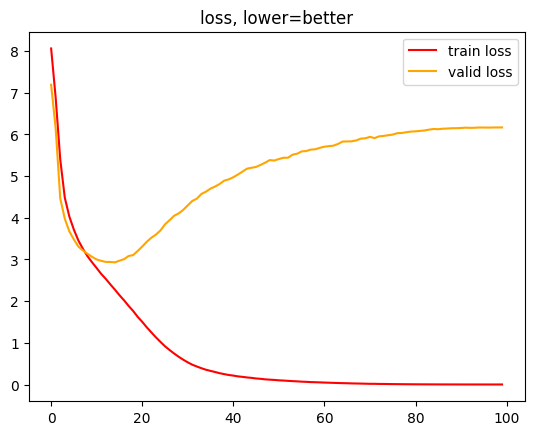

In [28]:
plt.plot(trainer.metrics['train_loss'],color='red',label='train loss')
plt.plot(trainer.metrics['val_loss'],color='orange',label='valid loss')
plt.title('loss, lower=better')
plt.legend()
plt.show()

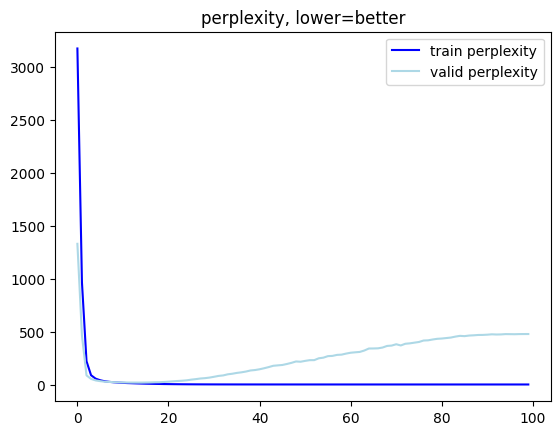

In [29]:
plt.plot(trainer.metrics['train_perplexity'],color='blue',label='train perplexity')
plt.plot(trainer.metrics['val_perplexity'],color='lightblue',label='valid perplexity')
plt.title('perplexity, lower=better')
plt.legend()
plt.show()

In [30]:
trainer.load_best_model()

In [31]:
trainer.save_model()

In [50]:
type(val_df)

pandas.core.frame.DataFrame

<class 'str'>
../Valid/ImageCLEFmedical_Caption_2024_valid_008662.jpg


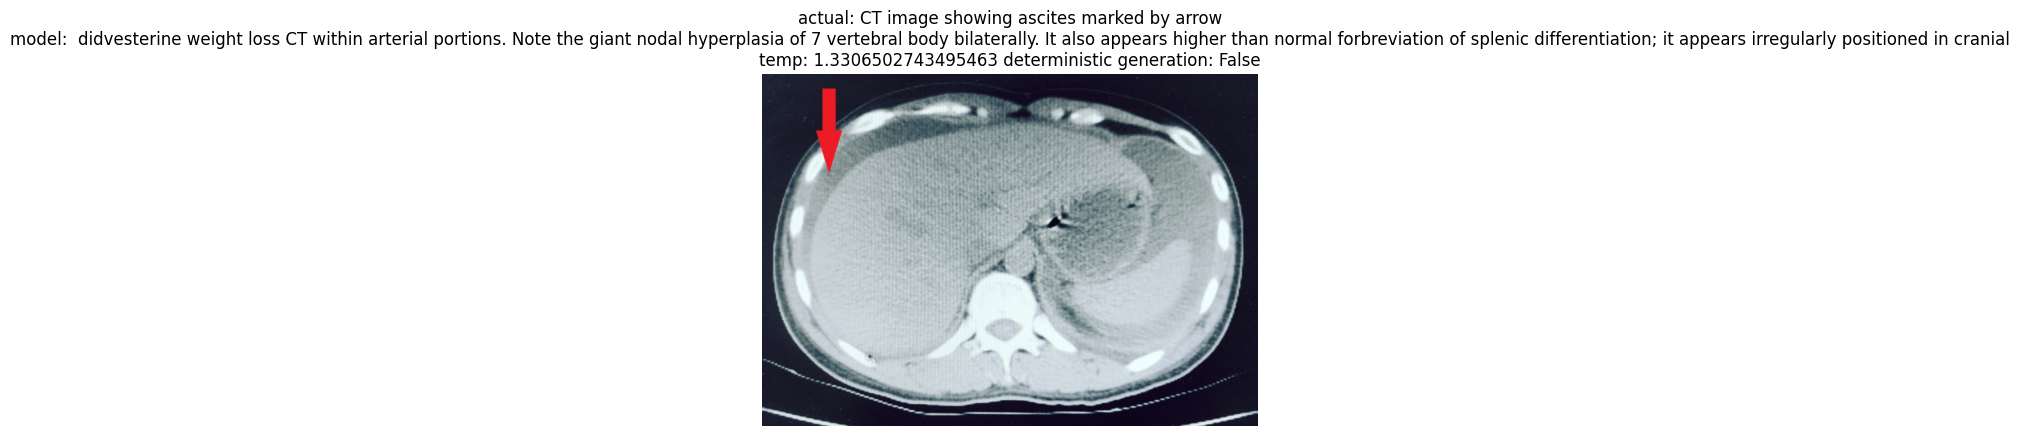

<class 'str'>
../Valid/ImageCLEFmedical_Caption_2024_valid_004283.jpg


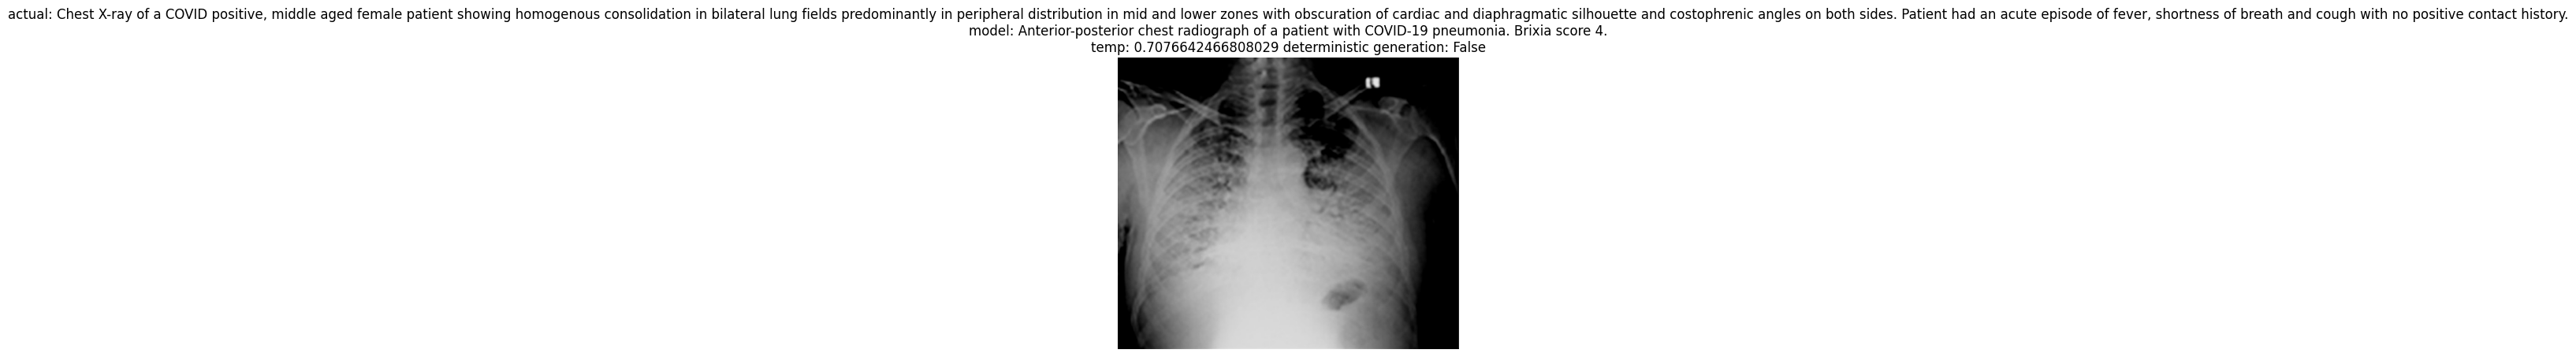

<class 'str'>
../Valid/ImageCLEFmedical_Caption_2024_valid_002525.jpg


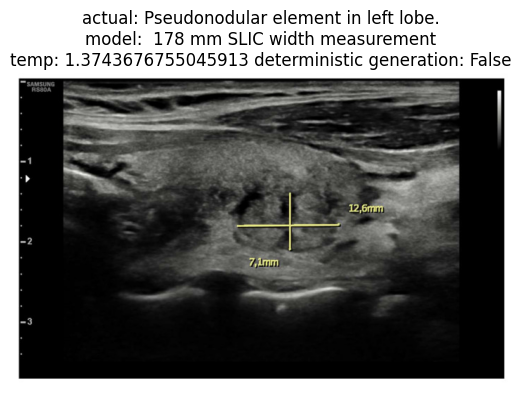

<class 'str'>
../Valid/ImageCLEFmedical_Caption_2024_valid_009559.jpg


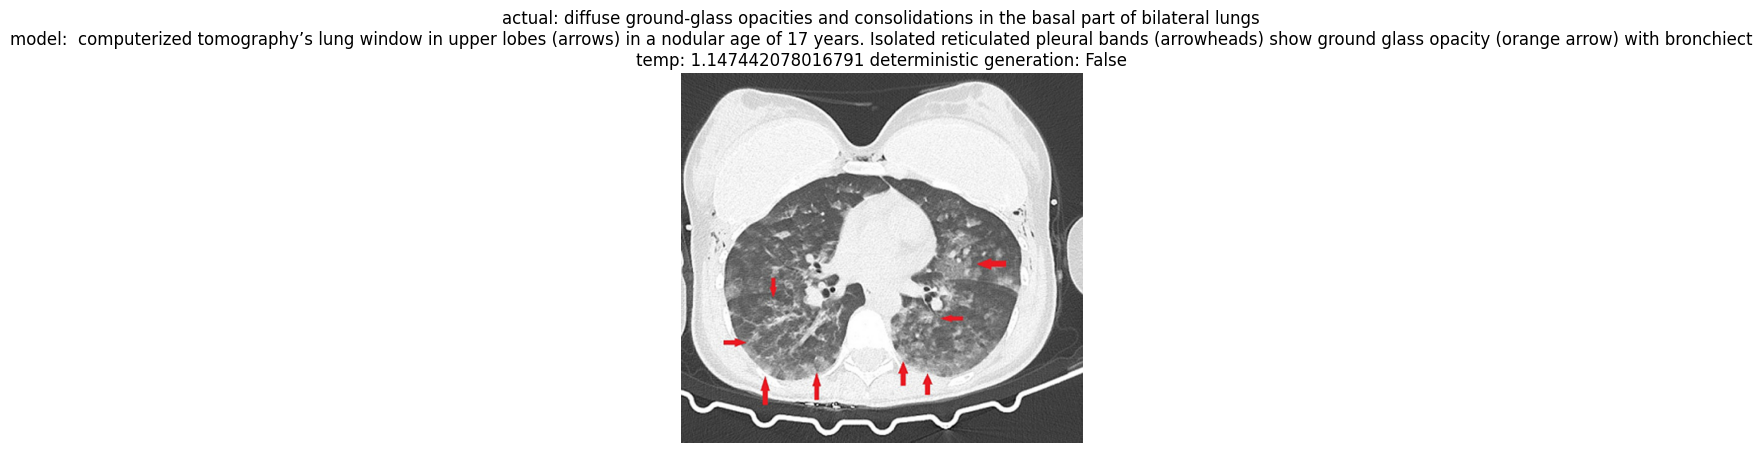

<class 'str'>
../Valid/ImageCLEFmedical_Caption_2024_valid_002149.jpg


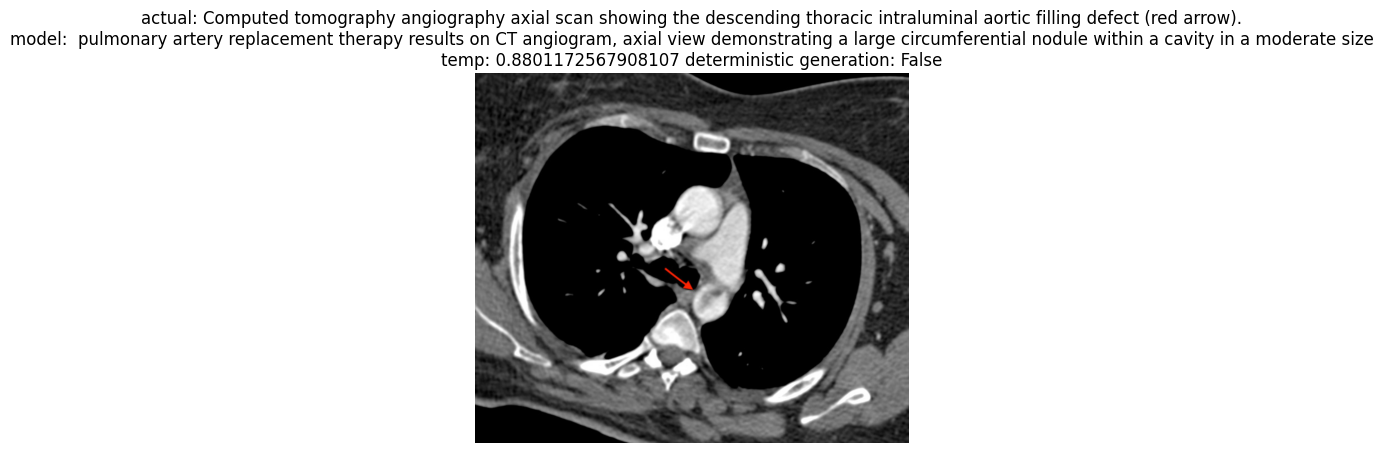

In [81]:
for i in range(5):
    det = False
    test = val_df.sample(n=1).values[0]
    test_img, test_caption = test[0],test[1]
    print(type(test_img))
    print(test_img)
    plt.imshow(Image.open(test_img).convert('RGB'))
    t = np.random.uniform(0.5,1.5)
    if i > 40:
        det = True
    gen_caption = trainer.generate_caption(test_img,temperature=t,deterministic=det)
    plt.title(f"actual: {test_caption}\nmodel: {gen_caption}\ntemp: {t} deterministic generation: {det}")
    plt.axis('off')
    plt.show()
    

In [ ]:
ls ../Test

In [51]:
import os 
test_path = "../Test/"
dir_list = os.listdir(path) 

In [37]:
len(dir_list)

17238

In [124]:
#os.path.join(test_path,dir_list[6])
test_path_list = []
ext = ('jpg','png')
#for i in tqdm(range(int(len(dir_list)))):
for i in tqdm(range(len(dir_list))):
    new_test_path = os.path.join(test_path, dir_list[i])
    #print(new_test_path)
    if new_test_path.endswith(ext):
        print(new_test_path)  # printing file name of desired extension
        test_path_list.append(new_test_path)
    else:
        continue

100%|██████████| 17238/17238 [00:00<00:00, 139642.99it/s]

../Test/ImageCLEFmedical_Caption_2024_test_013962.jpg
../Test/ImageCLEFmedical_Caption_2024_test_002336.jpg
../Test/ImageCLEFmedical_Caption_2024_test_013044.jpg
../Test/ImageCLEFmedical_Caption_2024_test_006097.jpg
../Test/ImageCLEFmedical_Caption_2024_test_009584.jpg
../Test/ImageCLEFmedical_Caption_2024_test_010810.jpg
../Test/ImageCLEFmedical_Caption_2024_test_003727.jpg
../Test/ImageCLEFmedical_Caption_2024_test_004075.jpg
../Test/ImageCLEFmedical_Caption_2024_test_004239.jpg
../Test/ImageCLEFmedical_Caption_2024_test_001656.jpg
../Test/ImageCLEFmedical_Caption_2024_test_014408.jpg
../Test/ImageCLEFmedical_Caption_2024_test_014419.jpg
../Test/ImageCLEFmedical_Caption_2024_test_002158.jpg
../Test/ImageCLEFmedical_Caption_2024_test_010992.jpg
../Test/ImageCLEFmedical_Caption_2024_test_015727.jpg
../Test/ImageCLEFmedical_Caption_2024_test_009603.jpg
../Test/ImageCLEFmedical_Caption_2024_test_005380.jpg
../Test/ImageCLEFmedical_Caption_2024_test_006013.jpg
../Test/ImageCLEFmedical_Cap

In [125]:
new_test_df = pd.DataFrame(test_path_list)

In [126]:
new_test_df[0].values[0]

'../Test/ImageCLEFmedical_Caption_2024_test_013962.jpg'

In [127]:
import cv2
image445 = cv2.imread(new_test_df[0].values[0])

In [128]:
str(new_test_df[0].values[0])

'../Test/ImageCLEFmedical_Caption_2024_test_013962.jpg'

In [129]:
#img22 = Image.open(new_test_df[0])
test_gen_caption = trainer.generate_caption(str(new_test_df[0].values[0]))

In [131]:
test_gen_caption

' x-ray of thoracic spine.'

In [132]:
vision_gpt_test_img_caption = []

In [ ]:
#path+dir_list[0]

for i in os.listdir(test_path):
    print(i)

In [135]:
str(new_test_df[0].values[16669])

'../Test/ImageCLEFmedical_Caption_2024_test_000543.jpg'

In [45]:
from tqdm import tqdm

In [136]:
test_img_path_for_df = []
caption_for_test_img = []

In [138]:
for i in tqdm(range(17238)):
    det = True
    #current_image = Image.open(test_path_list[i]).convert('RGB')
    t = np.random.uniform(0.5,1.5)
    current_img = str(new_test_df[0].values[i])
    #print(current_img)
    gen_caption = trainer.generate_caption(current_img,temperature=t,deterministic=det)
    test_img_path_for_df.append(str(new_test_df[0].values[i]))
    vision_gpt_test_img_caption.append(gen_caption)
    #print("caption for",gen_caption)
    #print(i)

100%|█████████▉| 17237/17238 [2:55:24<00:00,  1.64it/s]  


IndexError: index 17237 is out of bounds for axis 0 with size 17237

In [139]:
len(vision_gpt_test_img_caption)

17294

In [ ]:
#16669/17238

In [142]:
str(new_test_df[0].values[17237])

IndexError: index 17237 is out of bounds for axis 0 with size 17237

In [ ]:
vision_gpt_test_img_caption

In [140]:
visionGpt_gen_cap_df = pd.DataFrame(vision_gpt_test_img_caption)

In [144]:
visionGpt_gen_cap_df.to_csv(
    "visionGpt2_gen_results.csv",
    index=False
)

In [143]:
visionGpt_gen_cap_df.tail()

0
17289      A patient with a large left pneumoperitoneum.
17290  A patient with a history of a left humerus fra...
17291  A: Axial CT scan of the pelvis showing a large...
17292  -US image of the left kidney showing a hyperec...
17293  A: CT chest CT scan showing a large right-side...